In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15
                    }
                   )
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound, qExpectedImprovement
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable
from scipy.spatial import distance
torch.manual_seed(2021)
import pdb
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition import PosteriorMean

NUM_GRID_PERDIM = 100
BATCH_SIZE = 8
N_ITERATIONS = 10
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 8
NUM_FILTERS = 5

TARGET = [1,0,0.5]
expt = {}
EXPT_ID = 0

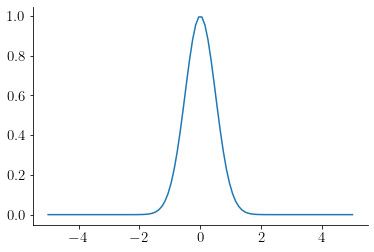

In [3]:
lambda_ = np.linspace(-5,5,num=100)
def gaussian(a, b,c):
    return a*np.exp(-np.power(lambda_ - b, 2.) / (2 * np.power(c, 2.)))

yt = gaussian(*TARGET)

fig, ax = plt.subplots()
ax.plot(lambda_, yt)
plt.show()

In [4]:
# define search space
A = [-5,5]
bounds = torch.tensor(A).reshape(2,1).to(**tkwargs)

In [5]:
from head import L2
metric = 'euclidean'
if metric=='l2':
    d = lambda yi, yt : -L2().distance(yi, yt, lambda_)
elif metric=='euclidean':
    d = lambda yi,yt : -distance.euclidean(yi,yt)

In [6]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()
    yi = gaussian(TARGET[0],x_np,TARGET[2])
    dist = d(yi, yt)
        
    expt[EXPT_ID] = [lambda_, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [7]:
def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 8 samples randomly torch.Size([8, 1]) torch.Size([8, 1])
0	[2.54576445]	[-4.18573809]
1	[-3.45083222]	[-4.18893194]
2	[1.513381]	[-3.97126079]
3	[0.45167208]	[-1.79951262]
4	[-3.70705888]	[-4.18887472]
5	[-4.94805926]	[-3.7635088]
6	[4.1697675]	[-4.18243361]
7	[1.87592745]	[-4.12643147]


In [8]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [9]:
def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [10]:
def agent(model):
    with torch.no_grad():
        test_x = torch.linspace(-5, 5, 100).to(**tkwargs)
        posterior = model.posterior(test_x)
        out_test = posterior.mean
        return test_x[out_test.argmax()].cpu().numpy()

In [11]:
# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = best_f)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    print('Optimal location from the surrogate : %2.4f'%float(agent(model)))
    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[0.12676016]	[-0.52886599]
1	[0.40214773]	[-1.61870778]
2	[0.70525885]	[-2.62230968]
3	[-0.09475802]	[-0.39604715]
4	[5.]	[-3.69600725]
5	[-0.62099964]	[-2.36957216]
6	[0.27573634]	[-1.13343465]
7	[0.56239313]	[-2.18126845]
Optimal location from the surrogate : 0.4545
Iteration : 2/10
0	[-0.00250743]	[-0.01050349]
1	[2.83477566]	[-4.18827105]
2	[3.87556541]	[-4.18850088]
3	[-1.90542805]	[-4.13307524]
4	[2.91750704]	[-4.18852758]
5	[-4.55358366]	[-4.10514498]
6	[-0.01806708]	[-0.07567589]
7	[-4.62398482]	[-4.06884575]
Optimal location from the surrogate : -0.0505
Iteration : 3/10
0	[3.27799033]	[-4.18890333]
1	[3.11528343]	[-4.18882132]
2	[0.01336283]	[-0.0559737]
3	[-2.00982173]	[-4.15190506]
4	[0.68183664]	[-2.55423832]
5	[1.55146151]	[-3.99582219]
6	[-0.081336]	[-0.34014961]
7	[-1.3460934]	[-3.83161187]
Optimal location from the surrogate : -0.0505
Iteration : 4/10
0	[4.96792449]	[-3.73809695]
1	[-0.02501175]	[-0.10475657]
2	[0.0

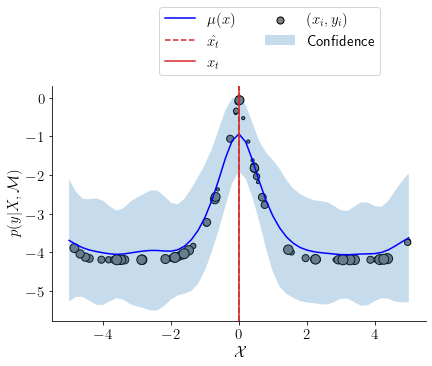

In [12]:
# Get into evaluation (predictive posterior) mode
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

model.eval()
mll.eval()
test_x = torch.linspace(-5, 5, 51).to(**tkwargs)
fig, ax = plt.subplots()
with torch.no_grad():
    posterior = model.posterior(test_x)
    lower, upper = posterior.mvn.confidence_region()
    ax.scatter(train_x.cpu().numpy(), train_obj.cpu().numpy(), s=10*batch_number,c='grey', 
               edgecolors=(0,0,0), label=r'$(x_{i}, y_{i})$')
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b', label=r'$\mu(x)$')
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), 
                    upper.cpu().numpy(), alpha=0.25, label='Confidence')

opt_x, opt_obj = selector(PosteriorMean(model), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
ax.axvline(opt_x, color='tab:red', ls='--', label=r'$\hat{x_{t}}$')
ax.axvline(TARGET[1], color='tab:red', label=r'$x_{t}$')
fig.legend(ncol=2,loc='center', bbox_to_anchor=(0.6, 1.1))
plt.tight_layout()
ax.set_xlabel(r'$\mathcal{X}$')
ax.set_ylabel(r'$p(y|X,\mathcal{M})$')
plt.show()

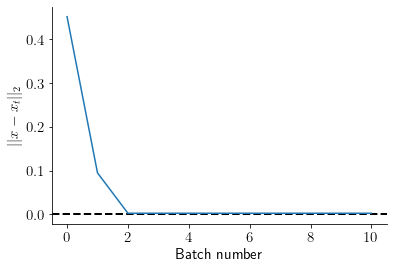

In [13]:
def plot_best_trace(ax, train_x, train_obj, target):
    train_x = train_x.cpu().numpy()
    proximities = np.abs(train_x-target[1])
    trace = np.asarray([min(proximities[batch_number<=b]) for b in np.unique(batch_number)])
    return ax.plot(np.arange(N_ITERATIONS+1),trace)

fig, ax = plt.subplots()
ax.axhline(0, label='Optimal', ls='--', lw='2.0', c='k')
plot_best_trace(ax, train_x, train_obj, TARGET)
ax.set_xlabel('Batch number')
ax.set_ylabel(r'$||x-x_{t}||_{2}$')
plt.show()